In [1]:
### Authorized to Xingjian Yin
### Time: 2025/04/17

## Part 1

You own the 3 portfolios in the file “initial_portfolio.csv.”   

The risk free rate is in “rf.csv.”  Daily prices 
of the stocks are in “DailyPrices.csv.”
You bought these portfolios at the end of 2023.  
Model the returns of stocks using CAPM with SPY as the market.  
Use the data up to the end of 2023 for the regression. Your holding period on these portfolios is to the end of the price data.   

Use you the fitted models to attribute the realized risk and return for each portfolio and the total 
portfolio for the holding period.  

Split the attribution between the systematic and idiosyncratic 
components.  

You should calculate the idiosyncratic contribution for each stock, but present the 
total in your output. Discuss the results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Read data from DailyPrices.csv
data = pd.read_csv('DailyPrices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.replace([np.inf, -np.inf], np.nan).dropna()

## Slice the data of 2023 to do regression
data_2023 = data.loc['2023-01-01':'2023-12-31']
data_2023 = data_2023.reset_index()
## read the rf rate from rf.csv
rf = pd.read_csv('rf.csv')
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf_2023 = rf.loc['2023-01-01':'2023-12-31']
rf = rf.replace([np.inf, -np.inf], np.nan).dropna()

market_returns = data_2023['SPY'].pct_change().dropna()
rf_2023 = rf_2023['rf'].iloc[:len(market_returns)].values
excess_market_returns = market_returns - rf_2023
excess_market_returns = (market_returns - rf_2023).dropna()

X = sm.add_constant(excess_market_returns)

## Do regression using CAPM with SPY as market index, and rf as risk-free rate
Models = {}
for stock in data_2023.columns[1:]:
    stock_returns = data_2023[stock].pct_change().dropna()  # stock returns
    excess_stock_returns = (stock_returns - rf_2023).dropna() # excess stock returns
    model = sm.OLS(excess_stock_returns, X.loc[excess_stock_returns.index]).fit()
    Models[stock] = model



In [3]:
for i in Models:
    print(i, Models[i].summary())

SPY                             OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.499e+32
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:31:07   Log-Likelihood:                 9540.9
No. Observations:                 249   AIC:                        -1.908e+04
Df Residuals:                     247   BIC:                        -1.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.547e-19   3.54e-19     -1.003     

In [4]:
## defin carino'K functions for factor i here

def carino_k(returns):
    daily_R=returns
    R= (daily_R+1).prod()-1
    daily_GR=np.log(daily_R+1)
    GR = np.sum(daily_GR)
    K = GR / R
    kt=daily_GR/K/daily_R
    kt =np.nan_to_num(kt, nan=0.0, posinf=0.0, neginf=0.0)
    return kt

In [ ]:

## read portfolio from initial_portfolio.csv
ini_portfolio = pd.read_csv('initial_portfolio.csv')

## holding period from 2023-12-29 to 2025-01-03
holding_period = data.loc['2023-12-29':'2025-01-03']
period_rf = rf.loc['2024-01-02':'2025-01-03']
period_rf = period_rf.replace([np.inf, -np.inf], np.nan).dropna()
total_portfolio=pd.DataFrame()
total_portfolio['Date'] = holding_period.index
total_portfolio.set_index('Date', inplace=True)
portfolio_results = {}
initial_total_value={}
for portfolio_name in ['A', 'B', 'C']:
    portfolio_data = ini_portfolio[ini_portfolio['Portfolio'] == portfolio_name]
    results = []
    portfolio=pd.DataFrame()
    portfolio['Date'] = holding_period.index
    portfolio.set_index('Date', inplace=True)
    

    market_returns = holding_period['SPY'].pct_change().dropna()
    excess_market_returns = market_returns - period_rf['rf']
    ## calculate the total return of each stock in the portfolio
    for _, row in portfolio_data.iterrows():
        stock = row['Symbol']
        shares = row['Holding']

        portfolio[stock] = holding_period[stock] * shares
    
    portfolio['Total']= portfolio.sum(axis=1)
    kt=carino_k(portfolio['Total'].pct_change().dropna())
    for _, row in portfolio_data.iterrows():
        portfolio_sys_ret=0
        stock = row['Symbol']
        shares = row['Holding']
        model = Models[stock]
        if stock not in total_portfolio.columns:
            total_portfolio[stock] = holding_period[stock] * shares
        else:
            total_portfolio[stock] += holding_period[stock] * shares
        
        
        ## return of holing period
        returns = holding_period[stock].pct_change().dropna()

        
        ## systematic return
        alpha = model.params['const']
        beta = model.params['SPY']
        systematic_returns = beta * excess_market_returns
        

        
        ## calculate total return, systematic contribution, and idiosyncratic contribution
        total_return = (returns + 1).prod() - 1
        
        systematic_return = np.dot(kt, systematic_returns)  
        portfolio_sys_ret += systematic_return
        rf_attribution = np.dot(kt, period_rf['rf'])
        idiosyncratic_contribution = total_return - systematic_return - rf_attribution
        
        results.append({
            'Stock': stock,
            'Total Return': total_return,
            'Systematic Contribution': systematic_return,
            'Rf Return': rf_attribution,
            'Idiosyncratic Contribution': idiosyncratic_contribution,
            'Risk': returns.std(),
            'Systematic Risk': systematic_returns.std()

        })
    ## calculate portfolio value

    initial_total_value[portfolio_name] = portfolio['Total'].iloc[0]
    portfolio['Total Beta'] = sum(Models[stock].params['SPY'] * portfolio[stock] / portfolio['Total'] for stock in portfolio.columns[0:-1])
    ## OLS regress the portfolio returns to market returns HERE
    portfolio_returns = portfolio['Total'].pct_change().dropna()- period_rf['rf']
    market_returns = holding_period['SPY'].pct_change().dropna()- period_rf['rf']
    aligned = portfolio_returns.align(market_returns, join='inner')
    y = aligned[0]
    X = sm.add_constant(aligned[1])
    ols_result = sm.OLS(y, X).fit()
    beta = ols_result.params[0]
    
    sigma_p=portfolio['Total'].pct_change().std()
    portfolio['Systematic Return'] = (portfolio['Total Beta'] * excess_market_returns)
    total_returns = portfolio['Total'].pct_change().dropna()
    total_return = (total_returns + 1).prod() - 1
    systematic_contribution = np.dot(kt,portfolio['Systematic Return'].iloc[1:])
    total_rf_return = np.dot(carino_k(total_returns), period_rf['rf'])
    idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return
    
    
    
    ## create a DataFrame to store the results
    portfolio_summary = pd.DataFrame(results)
    portfolio_summary.loc['Total'] = {
        'Stock': 'Portfolio',
        'Total Return': total_return,
        'Systematic Contribution': systematic_contribution,
        'Rf Return': total_rf_return,
        'Idiosyncratic Contribution': idiosyncratic_contribution,
        'Risk': sigma_p,
        'Systematic Risk': sigma_p * beta

    }
   
    portfolio_results[portfolio_name] = portfolio_summary

total_portfolio['Total']= total_portfolio.sum(axis=1)
total_portfolio['Total Beta'] = sum(Models[stock].params['SPY'] * total_portfolio[stock] / total_portfolio['Total'] for stock in total_portfolio.columns[0:-1])
total_portfolio['Systematic Return'] = total_portfolio['Total Beta'] * excess_market_returns

total_returns = total_portfolio['Total'].pct_change().dropna()
total_return = (total_returns + 1).prod() - 1
systematic_contribution = np.sum(np.dot(carino_k(total_return),total_portfolio['Systematic Return'].iloc[1:]))
total_rf_return = np.sum(np.dot(carino_k(total_returns), period_rf['rf']))
idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return

## regress
portfolio_returns = total_portfolio['Total'].pct_change().dropna()- period_rf['rf']
market_returns = holding_period['SPY'].pct_change().dropna()- period_rf['rf']
aligned = portfolio_returns.align(market_returns, join='inner')
y = aligned[0]
X = sm.add_constant(aligned[1])
ols_result = sm.OLS(y, X).fit()
beta = ols_result.params[0]


sigma_p=total_portfolio['Total'].pct_change().std()
portfolio_results['Total Portfolio']= pd.DataFrame({
    'Stock': 'Total Portfolio of A,B,C',
    'Total Return': total_return,
    'Systematic Contribution': systematic_contribution,
    'Rf Return': total_rf_return,
    'Idiosyncratic Contribution': idiosyncratic_contribution,
    'Risk': sigma_p,
    'Systematic Risk': beta * sigma_p

}, index=['Total'])
## calculate total portfolio results

## print the results
for portfolio_name, summary in portfolio_results.items():
    print(f"Portfolio {portfolio_name} Results:")
    print(summary.loc['Total'])
    print("\n")







Portfolio A Results:
Stock                         Portfolio
Total Return                   0.136642
Systematic Contribution        0.194457
Rf Return                      0.054346
Idiosyncratic Contribution    -0.112161
Risk                           0.007418
Systematic Risk                0.006303
Name: Total, dtype: object


Portfolio B Results:
Stock                         Portfolio
Total Return                   0.203526
Systematic Contribution        0.185674
Rf Return                      0.055949
Idiosyncratic Contribution    -0.038097
Risk                           0.006867
Systematic Risk                0.005269
Name: Total, dtype: object


Portfolio C Results:
Stock                         Portfolio
Total Return                   0.281172
Systematic Contribution        0.203779
Rf Return                      0.057783
Idiosyncratic Contribution     0.019611
Risk                           0.007924
Systematic Risk                0.007355
Name: Total, dtype: object


Portfolio 

C:\Users\Xingjian Yin\AppData\Local\Temp\ipykernel_35428\2428763813.py:111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  total_portfolio['Total Beta'] = sum(Models[stock].params['SPY'] * total_portfolio[stock] / total_portfolio['Total'] for stock in total_portfolio.columns[0:-1])
C:\Users\Xingjian Yin\AppData\Local\Temp\ipykernel_35428\2428763813.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  total_portfolio['Systematic Return'] = total_portfolio['Total Beta'] * excess_market_returns


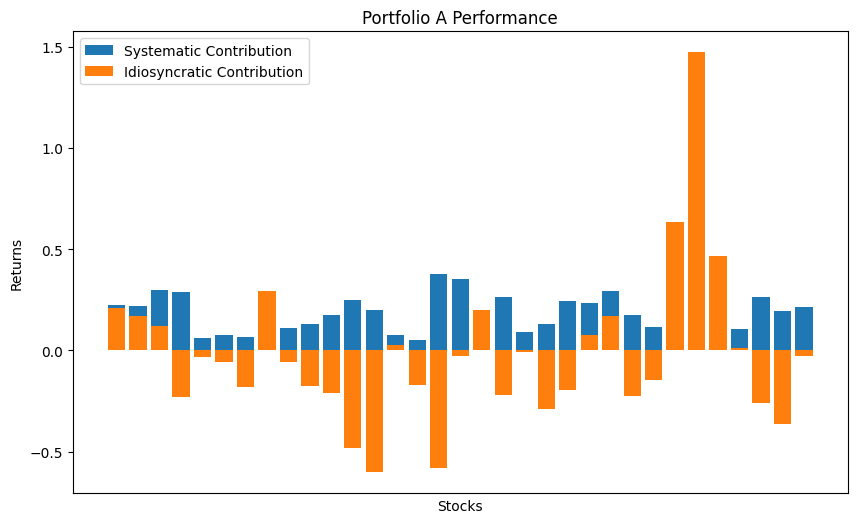

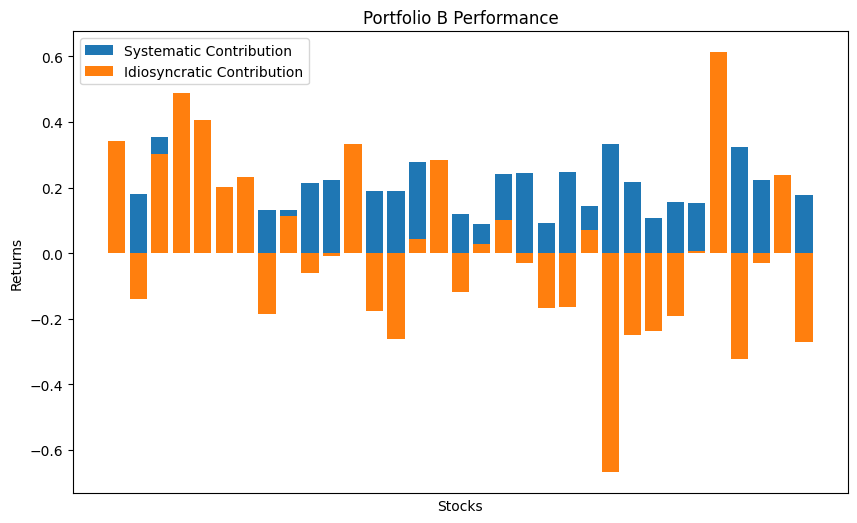

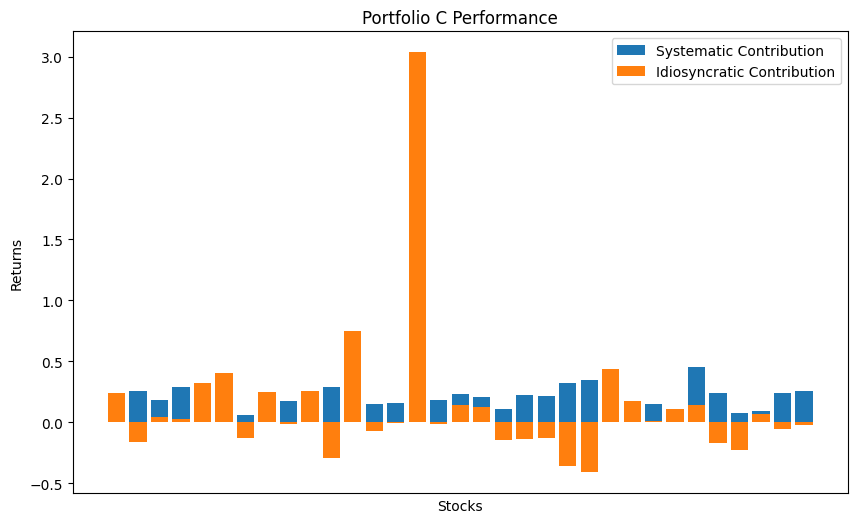

In [6]:
## plot the results
for portfolio_name, total_summary in portfolio_results.items():
    if portfolio_name=="Total Portfolio":
        break

    plt.figure(figsize=(10, 6))

    ## not include the last row (Total) in the plot
    total_summary = total_summary[:-1]
    plt.bar(total_summary.index, total_summary['Systematic Contribution'], label='Systematic Contribution')
    plt.bar(total_summary.index, total_summary['Idiosyncratic Contribution'], label='Idiosyncratic Contribution')
    ## hide the x-axis labels
    plt.xticks([])

    plt.title(f'Portfolio {portfolio_name} Performance')
    plt.xlabel('Stocks')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()


## Discuss the result



## Part 2



In [105]:
expected_rf = rf.loc[:'2023-12-28']['rf'].mean()
expected_market_return = data.loc[:'2023-12-28']['SPY'].pct_change().mean()
expected_returns = {}
for stock, model in Models.items():
    beta = model.params['SPY']
    expected_returns[stock] = expected_rf + beta * (expected_market_return - expected_rf)


from scipy.optimize import minimize


Portfolio_weights = {}
for portfolio_name in ['A', 'B', 'C']:
    sub_expected_returns = {}
    sub_portfolio_stocks = ini_portfolio[ini_portfolio['Portfolio'] == portfolio_name]['Symbol'].tolist()
    sub_portfolio_returns = data[sub_portfolio_stocks].loc[:'2023-12-28'].pct_change().dropna()
    cov_matrix = sub_portfolio_returns.cov()
    
    for stock in sub_portfolio_stocks:
        sub_expected_returns[stock] = expected_returns[stock]
    

    ## Sharpe ratio as the optimization target
    def negative_sharpe(weights, sub_expected_returns, cov_matrix, rf):
        portfolio_return = np.dot(weights, list(sub_expected_returns.values()))
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - rf) / portfolio_volatility

    # initialze the weights
    num_stocks = len(sub_portfolio_stocks)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    bounds = [(0, 1) for _ in range(num_stocks)] 
    initial_weights = np.array([1/num_stocks] * num_stocks)

    optimal_result = minimize(negative_sharpe, initial_weights, args=(sub_expected_returns, cov_matrix, expected_rf),
                            method='SLSQP', bounds=bounds, constraints=constraints)

    optimal_weights = optimal_result.x
    Portfolio_weights[portfolio_name] = optimal_weights

In [106]:
## print the optimal weights
for portfolio_name, weights in Portfolio_weights.items():
    print(f"Optimal Weights for Portfolio {portfolio_name}:")
    for stock, weight in zip(ini_portfolio[ini_portfolio['Portfolio'] == portfolio_name]['Symbol'].tolist(), weights):
        print(f"{stock}: {weight:.4f}")
    print("\n")

Optimal Weights for Portfolio A:
WFC: 0.0179
ETN: 0.0377
AMZN: 0.0918
QCOM: 0.0112
LMT: 0.0268
KO: 0.0567
JNJ: 0.0233
ISRG: 0.0427
XOM: 0.0000
MDT: 0.0000
DHR: 0.0194
PLD: 0.0329
BA: 0.0158
PG: 0.0763
MRK: 0.0466
AMD: 0.0102
BX: 0.0422
PM: 0.0424
SCHW: 0.0000
VZ: 0.0125
COP: 0.0330
ADI: 0.0522
BAC: 0.0315
NOW: 0.0478
TMO: 0.0123
CVX: 0.0305
ANET: 0.0104
NVDA: 0.0512
GE: 0.0128
GILD: 0.0261
MU: 0.0008
CMCSA: 0.0636
DIS: 0.0215


Optimal Weights for Portfolio B:
AXP: 0.0215
HON: 0.0500
META: 0.0322
NFLX: 0.0158
PGR: 0.0000
LLY: 0.0207
JPM: 0.0208
VRTX: 0.0171
TJX: 0.0548
EQIX: 0.0363
AAPL: 0.1193
FI: 0.0305
DE: 0.0309
SBUX: 0.0217
GOOGL: 0.0542
T: 0.0200
ABT: 0.0251
BMY: 0.0151
MS: 0.0618
CRM: 0.0235
PFE: 0.0119
SPGI: 0.0170
BRK-B: 0.0438
ADBE: 0.0440
ACN: 0.0280
AMGN: 0.0106
LIN: 0.0170
V: 0.0097
WMT: 0.0479
AMAT: 0.0486
CAT: 0.0114
RTX: 0.0078
UNP: 0.0306


Optimal Weights for Portfolio C:
IBM: 0.0121
TXN: 0.0683
ADP: 0.0314
GOOG: 0.0664
ORCL: 0.0142
BSX: 0.0084
UNH: 0.0357
TMUS: 0.012

In [116]:
## create a new portfolio with the optimal weights
# Initialize a dictionary to store results for optimal portfolios
optimal_portfolio_results = {}
for portfolio_name, weights in Portfolio_weights.items():
    sub_portfolio_stocks = ini_portfolio[ini_portfolio['Portfolio'] == portfolio_name]['Symbol'].tolist()
    results = []
    portfolio = pd.DataFrame()
    portfolio['Date'] = holding_period.index
    portfolio.set_index('Date', inplace=True)

    # Calculate the daily value of the optimal portfolio
    
    for i, stock in enumerate(sub_portfolio_stocks):
        weight = weights[i]
        initial_value = initial_total_value[portfolio_name]
        portfolio[stock] = initial_value * weight/holding_period[stock].iloc[0] * holding_period[stock]

    # Calculate the total portfolio value
    portfolio['Total'] = portfolio.sum(axis=1)

    # Calculate systematic and idiosyncratic contributions for each stock
    for stock in sub_portfolio_stocks:
        model = Models[stock]
        beta = model.params['SPY']
        returns = holding_period[stock].pct_change().dropna()
        market_returns = holding_period['SPY'].pct_change().dropna()
        rf_holding = period_rf['rf']
        excess_returns = returns - rf_holding
        excess_market_returns = market_returns - rf_holding

        # Systematic returns
        systematic_returns = beta * excess_market_returns



        # Aggregate results
        total_return = (returns + 1).prod() - 1
        systematic_contribution = np.sum(np.dot(carino_k(returns), systematic_returns))
        total_rf_return = np.sum(np.dot(carino_k(returns), rf_holding))
        idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return

        results.append({
            'Stock': stock,
            'Total Return': total_return,
            'Systematic Contribution': systematic_contribution,
            'Rf Return': total_rf_return,
            'Idiosyncratic Contribution': idiosyncratic_contribution,
            'Risk': returns.std(),
            'Systematic Risk': systematic_returns.std()
        })

    # Calculate portfolio-level metrics
    portfolio['Total Beta'] = sum(
        Models[stock].params['SPY'] * portfolio[stock] / portfolio['Total'] for stock in sub_portfolio_stocks
    )
    portfolio['Systematic Return'] = portfolio['Total Beta'] * excess_market_returns
    total_rf_return = np.sum(np.dot(carino_k(portfolio['Total'].pct_change().dropna()), period_rf['rf']))

    # Aggregate portfolio-level results
    total_return = portfolio['Total'].iloc[-1] / initial_total_value[portfolio_name] - 1
    systematic_contribution = np.sum(np.dot(carino_k(portfolio['Total'].pct_change().dropna()), portfolio['Systematic Return'].iloc[1:]))
    idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return
    
    ## OLS regress the portfolio returns to market returns HERE
    portfolio_returns = portfolio['Total'].pct_change().dropna()- period_rf['rf']
    market_returns = holding_period['SPY'].pct_change().dropna()- period_rf['rf']
    aligned = portfolio_returns.align(market_returns, join='inner')
    y = aligned[0]
    X = sm.add_constant(aligned[1])
    ols_result = sm.OLS(y, X).fit()
    beta = ols_result.params[0]
    
    sigma_p=portfolio['Total'].pct_change().std()


   

    portfolio_summary = pd.DataFrame(results)
    portfolio_summary.loc['Total'] = {
        'Stock': 'Portfolio',
        'Total Return': total_return,
        'Systematic Contribution': systematic_contribution,
        'Rf Return': total_rf_return,
        'Idiosyncratic Contribution': idiosyncratic_contribution,
        'Risk': sigma_p,
        'Systematic Risk': sigma_p * beta
    }

    optimal_portfolio_results[portfolio_name] = portfolio_summary

# Output the results for optimal portfolios
for portfolio_name, summary in optimal_portfolio_results.items():
    print(f"Optimal Portfolio {portfolio_name} Results:")
    print(summary.loc['Total'])
    print("\n")

Optimal Portfolio A Results:
Stock                         Portfolio
Total Return                   0.288159
Systematic Contribution        0.222812
Rf Return                      0.057956
Idiosyncratic Contribution     0.007392
Risk                           0.008048
Systematic Risk                0.007761
Name: Total, dtype: object


Optimal Portfolio B Results:
Stock                         Portfolio
Total Return                   0.258774
Systematic Contribution         0.20778
Rf Return                       0.05726
Idiosyncratic Contribution    -0.006267
Risk                           0.007374
Systematic Risk                0.006446
Name: Total, dtype: object


Optimal Portfolio C Results:
Stock                         Portfolio
Total Return                   0.304962
Systematic Contribution        0.214734
Rf Return                      0.058335
Idiosyncratic Contribution     0.031893
Risk                           0.008234
Systematic Risk                0.007999
Name: Total, dt

## Part 3

## Part 4


In [117]:
from scipy.stats import norm, skewnorm, jf_skew_t, norminvgauss
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import minimize
from scipy.special import gamma

In [119]:
# Define a function for Normal Inverse Gaussian (NIG) PDF
def fit_norminvgauss(data):
    params = norminvgauss.fit(data)
    return params
# Fit Skew Normal distribution
def fit_skewnorm(data):
    params = skewnorm.fit(data)
    return params

# Fit Generalized T distribution
def fit_generalized_t(data):
    params = jf_skew_t.fit(data)
    return params

# Fit Normal distribution
def fit_normal(data):
    params = norm.fit(data)
    return params

# Evaluate AICc
def calculate_aicc(log_likelihood, num_params, num_data):
    aic = 2 * num_params - 2 * log_likelihood
    aicc = aic + (2 * num_params * (num_params + 1)) / (num_data - num_params - 1)
    return aicc

# Fit all distributions and choose the best fit
def fit_distributions(data):
    results = {}
    num_data = len(data)
    
    # Fit Normal
    normal_params = fit_normal(data)
    normal_loglik = np.sum(norm.logpdf(data, *normal_params))
    results['Normal'] = {
        'params': normal_params,
        'log_likelihood': normal_loglik,
        'aicc': calculate_aicc(normal_loglik, len(normal_params), num_data)
    }
    
    # Fit Skew Normal
    skewnorm_params = fit_skewnorm(data)
    skewnorm_loglik = np.sum(skewnorm.logpdf(data, *skewnorm_params))
    results['Skew Normal'] = {
        'params': skewnorm_params,
        'log_likelihood': skewnorm_loglik,
        'aicc': calculate_aicc(skewnorm_loglik, len(skewnorm_params), num_data)
    }
    
    # Fit Generalized T
    generalized_t_params = fit_generalized_t(data)
    generalized_t_loglik = np.sum(jf_skew_t.logpdf(data, *generalized_t_params))
    results['Generalized T'] = {
        'params': generalized_t_params,
        'log_likelihood': generalized_t_loglik,
        'aicc': calculate_aicc(generalized_t_loglik, len(generalized_t_params), num_data)
    }
    
    # Fit NIG
    nig_params = fit_norminvgauss(data)
    if nig_params is not None:
        nig_loglik = np.sum(norminvgauss.logpdf(data, *nig_params))
        results['NIG'] = {
            'params': nig_params,
            'log_likelihood': nig_loglik,
            'aicc': calculate_aicc(nig_loglik, len(nig_params), num_data)
        }
    
    # Choose the best fit based on AICc
    best_fit = min(results.items(), key=lambda x: x[1]['aicc'])
    return best_fit, results

# Example: Fit distributions for each stock
  # Pre-holding period data

stock_results = {}
data1= data.loc[:'2023-12-29']
for stock in data.columns:
    stock_data = data1[stock].dropna().pct_change().dropna()
    best_fit, all_results = fit_distributions(stock_data)
    stock_results[stock] = {
        'best_fit': best_fit,
        'all_results': all_results
    }

# Print results
for stock, result in stock_results.items():
    print(f"Stock: {stock}")
    print(f"Best Fit: {result['best_fit'][0]}")
    print(f"Parameters: {result['best_fit'][1]['params']}")
    print(f"AICc: {result['best_fit'][1]['aicc']}")
    print()

Stock: SPY
Best Fit: Normal
Parameters: (np.float64(0.0009849959688576415), np.float64(0.008230265429090227))
AICc: -1679.6884626519254

Stock: AAPL
Best Fit: NIG
Parameters: (np.float64(2.4804569873227584), np.float64(0.12425037262616584), np.float64(0.0008484050590415752), np.float64(0.019668692047269416))
AICc: -1474.5587806480205

Stock: NVDA
Best Fit: Generalized T
Parameters: (np.float64(4.025583996110183), np.float64(2.621656669193187), np.float64(-0.010506717899148152), np.float64(0.02157339489553378))
AICc: -1089.2460669367122

Stock: MSFT
Best Fit: Generalized T
Parameters: (np.float64(4.716623695100571), np.float64(3.9338070658637614), np.float64(-0.0024524994688954996), np.float64(0.013645585717287847))
AICc: -1359.7534783927445

Stock: AMZN
Best Fit: Generalized T
Parameters: (np.float64(3.173819185666194), np.float64(2.8106559083121363), np.float64(-0.00079550563958447), np.float64(0.01683209402799969))
AICc: -1230.6016247174869

Stock: META
Best Fit: Generalized T
Parame

In [120]:
import scipy.stats as stats
import mpmath as mp

In [123]:
def CDF(stock):
    if stock_results[stock]['best_fit'][0] == 'Generalized T':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.jf_skew_t.cdf(data[stock].pct_change().dropna(), *params)
    elif stock_results[stock]['best_fit'][0] == 'Normal':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.norm.cdf(data[stock].pct_change().dropna(), *params)
    elif stock_results[stock]['best_fit'][0] == 'Skew Normal':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.skewnorm.cdf(data[stock].pct_change().dropna(), *params)
    elif stock_results[stock]['best_fit'][0] == 'NIG':
        params = stock_results[stock]['best_fit'][1]['params']
        return norminvgauss.cdf(data[stock].pct_change().dropna(), *params)

daily_returns=pd.DataFrame()
daily_returns['Date'] = data.pct_change().dropna().index
daily_returns.set_index('Date', inplace=True)
for stock in data.columns:
    daily_returns[stock] = CDF(stock)
    daily_returns[stock] = norm.ppf(daily_returns[stock])
    
spearman_rank = daily_returns.corr(method='spearman')
np.random.seed(33)
n_samples =  1000
random_samples = np.random.multivariate_normal(np.zeros(len(daily_returns.columns)), spearman_rank, size=n_samples)
random_samples = pd.DataFrame(random_samples, columns=daily_returns.columns)
random_samples = norm.cdf(random_samples)



In [124]:
## the processor always crush here, so I do it separately. Yet found no problem.
random_samples = pd.DataFrame(random_samples, columns=daily_returns.columns)


In [126]:
def ppf(data, stock):
    data[stock]=np.clip(data[stock], 1e-8, 1-1e-8)
    if stock_results[stock]['best_fit'][0] == 'Generalized T':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.jf_skew_t.ppf(data[stock], *params)
    elif stock_results[stock]['best_fit'][0] == 'Normal':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.norm.ppf(data[stock], *params)
    elif stock_results[stock]['best_fit'][0] == 'Skew Normal':
        params = stock_results[stock]['best_fit'][1]['params']
        return stats.skewnorm.ppf(data[stock], *params)
    elif stock_results[stock]['best_fit'][0] == 'NIG':
        params = stock_results[stock]['best_fit'][1]['params']
        try: 
            values=norminvgauss.ppf(data[stock], *params)
            return values
        except:
            values = np.zeros(len(data[stock]))
            return values

In [17]:
temp=ppf(random_samples, 'PLTR')

In [127]:


for stock in random_samples.columns:
    print(stock)
    random_samples[stock] = ppf(random_samples, stock)

SPY
AAPL
NVDA
MSFT
AMZN
META
GOOGL
AVGO
TSLA
GOOG
BRK-B
JPM
LLY
V
XOM
UNH
MA
COST
PG
WMT
HD
NFLX
JNJ
ABBV
CRM
BAC
ORCL
MRK
CVX
KO
CSCO
WFC
ACN
NOW
MCD
PEP
IBM
DIS
TMO
LIN
ABT
AMD
ADBE
PM
ISRG
GE
GS
INTU
CAT
QCOM
TXN
VZ
AXP
T
BKNG
SPGI
MS
RTX
PLTR
PFE
BLK
DHR
NEE
HON
CMCSA
PGR
LOW
AMGN
UNP
TJX
AMAT
UBER
C
BSX
ETN
COP
BA
BX
SYK
PANW
ADP
FI
ANET
GILD
BMY
SCHW
TMUS
DE
ADI
VRTX
SBUX
MMC
MDT
CB
LMT
KKR
MU
PLD
LRCX
EQIX


In [128]:
portfolio_A = ini_portfolio[ini_portfolio['Portfolio'] == 'A']
symbols_A = portfolio_A['Symbol'].tolist()
holdings_A = dict(zip(portfolio_A['Symbol'], portfolio_A['Holding']))
portfolio_B = ini_portfolio[ini_portfolio['Portfolio'] == 'B']
symbols_B = portfolio_B['Symbol'].tolist()
holdings_B = dict(zip(portfolio_B['Symbol'], portfolio_B['Holding']))
portfolio_C = ini_portfolio[ini_portfolio['Portfolio'] == 'C']
symbols_C = portfolio_C['Symbol'].tolist()
holdings_C = dict(zip(portfolio_C['Symbol'], portfolio_C['Holding']))

A=pd.DataFrame()
A['Date'] = data.index
A.set_index('Date', inplace=True)
A=A.loc[['2023-12-29']]
for stock in symbols_A:
    A[stock] = data[stock] * holdings_A[stock]

B=pd.DataFrame()
B['Date'] = data.index
B.set_index('Date', inplace=True)
B=B.loc[['2023-12-29']]
for stock in symbols_B:
    B[stock] = data[stock] * holdings_B[stock]
C=pd.DataFrame()
C['Date'] = data.index
C.set_index('Date', inplace=True)
C=C.loc[['2023-12-29']]
for stock in symbols_C:
    C[stock] = data[stock] * holdings_C[stock]

In [129]:
print(random_samples)

          SPY      AAPL      NVDA      MSFT      AMZN      META     GOOGL  \
0    0.001373  0.024301  0.002952  0.016532  0.017729  0.010198  0.011058   
1   -0.002116  0.005906 -0.003965 -0.004954 -0.000002 -0.004289 -0.005993   
2    0.001459 -0.001787 -0.012236  0.006488 -0.008486  0.004814  0.011236   
3    0.002426 -0.000532  0.002664  0.009519  0.008418  0.012062  0.015102   
4   -0.004489  0.004826 -0.034653 -0.014748 -0.019525 -0.014780 -0.008322   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.002646  0.018974 -0.024318  0.020207  0.010779  0.012644  0.006042   
996  0.002918 -0.008228  0.048768 -0.002268 -0.004249  0.002108 -0.015569   
997  0.012032  0.029666  0.025650  0.024849  0.028945  0.107620  0.024245   
998  0.007930  0.005388  0.022823  0.024643  0.007790  0.019848  0.052833   
999  0.007689  0.015570  0.033598  0.027127  0.024471  0.022107  0.012690   

         AVGO      TSLA      GOOG  ...      SBUX       MMC       MDT  \
0  

In [130]:
### Using the data on 2023-12-29 in Part1
portfolios={'A':A, 'B':B, 'C':C}
def compute_var_es(portfolio_name):
    sample_results =np.zeros_like(random_samples)
    sample_results = pd.DataFrame(sample_results, columns=random_samples.columns)
    if portfolio_name == 'Total':
        current_portfolio = total_portfolio.loc[['2023-12-29']]
        current_portfolio = current_portfolio.drop(columns=['Total', 'Total Beta', 'Systematic Return'])
        for stock in current_portfolio.columns:
            sample_results[stock] = (1+random_samples[stock].values)* current_portfolio[stock].values
    else:
        current_portfolio = portfolios[portfolio_name]
   
        for stock in current_portfolio.columns:

            sample_results[stock] = (1+random_samples[stock].values)* current_portfolio[stock].values
  
    current_value = current_portfolio.sum(axis=1).values[0]
    print(f'{portfolio_name} current value: {current_value}')
    sample_results['Total']= sample_results.sum(axis=1)
    var_95 = np.percentile(sample_results['Total'], 5)
    var= current_value - var_95
    es_95 = sample_results[sample_results['Total'] <= var_95]['Total'].mean()
    es = current_value - es_95
    return var, es

for portfolio_name in ['A', 'B', 'C', 'Total']:
    var, es = compute_var_es(portfolio_name)
    print(f"1 Day 5% for Portfolio {portfolio_name} VaR: {var:.2f}, ES: {es:.2f}")



A current value: 295444.60820007324
1 Day 5% for Portfolio A VaR: 4088.77, ES: 5189.09
B current value: 280904.48240852356
1 Day 5% for Portfolio B VaR: 3532.09, ES: 4456.19
C current value: 267591.4399547577
1 Day 5% for Portfolio C VaR: 3464.35, ES: 4399.78
Total current value: 843940.5305633545
1 Day 5% for Portfolio Total VaR: 10534.53, ES: 13524.42


C:\Users\Xingjian Yin\AppData\Local\Temp\ipykernel_35428\2929858830.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_results['Total']= sample_results.sum(axis=1)


In [131]:
from scipy.linalg import eigh
from scipy.linalg import sqrtm
from numpy.linalg import norm

In [132]:
daily_returns = data.pct_change().dropna()
cov_matrix = daily_returns.cov()
std_devs=np.sqrt(np.diag(cov_matrix))
init_corr_matrix = np.diag(1/std_devs) @ cov_matrix @ np.diag(1/std_devs) 

In [133]:
def projection1(matrix):
    matrix1 = matrix.copy()
    np.fill_diagonal(matrix1, 1)
    return matrix1
    

def projection2(matrix):
    eigvals, eigvecs = eigh(matrix)
    eigvals[eigvals < 0] = 1e-8
    eigvals = np.diag(eigvals)
    return eigvecs @ eigvals @ eigvecs.T #weight as 1, neglected

std_devs=np.sqrt(np.diag(cov_matrix))

init_corr_matrix = np.diag(1/std_devs) @ cov_matrix @ np.diag(1/std_devs)

def from_corr_to_cov(corr_matrix, std_devs):
    return np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

tol=1e-12
max_iter=1000
def higham_psd(matrix):
    global tol, max_iter
    Yk=matrix
    delta_Sk=np.zeros(matrix.shape)
    for i in range(max_iter):
        Rk=Yk-delta_Sk
        Xk=projection2(Rk)
        delta_Sk=Xk-Rk
        if norm(Yk-projection1(Xk), 'fro')<tol:
            Yk=projection1(Xk)
            print("iteration",i)
            break
        Yk=projection1(Xk)
    return Yk    



higham_corr_matrix = higham_psd(init_corr_matrix)
higham_cov_matrix = from_corr_to_cov(higham_corr_matrix, std_devs)

iteration 0


In [134]:

L = np.linalg.cholesky(higham_cov_matrix)
n_samples = 1000
z = np.random.randn(n_samples, cov_matrix.shape[0])
samples=[]
for i in z:
    samples.append(L @ i)
samples=pd.DataFrame(samples)
samples.columns = data.columns  


def compute_var_es_multinorm(portfolio_name):
    temp_samples =np.zeros_like(samples)
    temp_samples = pd.DataFrame(temp_samples)
    if portfolio_name == 'Total':
        current_portfolio = total_portfolio.loc[['2023-12-29']]
        current_portfolio = current_portfolio.drop(columns=['Total', 'Total Beta', 'Systematic Return'])
        for stock in current_portfolio.columns:
            temp_samples[stock] = (1+samples[stock].values)* current_portfolio[stock].values
    else:
        current_portfolio = portfolios[portfolio_name]
   
        for stock in current_portfolio.columns:
            temp_samples[stock] = (1+samples[stock].values)* current_portfolio[stock].values
    temp_samples['Total']= temp_samples.sum(axis=1)
    current_value = current_portfolio.sum(axis=1).values[0]
    var_95 = np.percentile(temp_samples['Total'], 5)
    var= current_value - var_95
    es_95 = temp_samples[temp_samples['Total'] <= var_95]['Total'].mean()
    es = current_value - es_95
    return var, es

for portfolio_name in ['A', 'B', 'C', 'Total']:
    var, es = compute_var_es_multinorm(portfolio_name)
    print(f"1 Day 5% for Portfolio {portfolio_name} VaR: {var:.2f}, ES: {es:.2f}")

            

1 Day 5% for Portfolio A VaR: 3626.53, ES: 4679.65
1 Day 5% for Portfolio B VaR: 3282.68, ES: 4240.80
1 Day 5% for Portfolio C VaR: 3376.62, ES: 4335.76
1 Day 5% for Portfolio Total VaR: 9783.77, ES: 12716.73


C:\Users\Xingjian Yin\AppData\Local\Temp\ipykernel_35428\3722452345.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp_samples['Total']= temp_samples.sum(axis=1)


In [ ]:
var_95= np.percentile(total_portfolio['Total'], 5)
es_95 = total_portfolio[total_portfolio['Total'] <= var_95]['Total'].mean()
var = total_portfolio['Total'].iloc[0] - var_95
es = total_portfolio['Total'].iloc[0] - es_95
print("Historical Simulation: ")
print(f"1 Day 5% for Portfolio Total VaR: {var:.2f}, ES: {es:.2f}")


SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' (1030861874.py, line 6)

In [135]:
def compute_es(weights,portfolio):
    simulated_returns = np.sum(portfolio @ np.diag(weights), axis=0)
    
    var_95 = np.percentile(simulated_returns, 5)
    es_95 = simulated_returns[simulated_returns <= var_95].mean()
    return -es_95

epsilon = 1e-6

def CES(weights, portfolio):
    original_es = compute_es(weights, portfolio)
    gradient = np.zeros_like(weights)
    for i in range(len(weights)):
        perturbed_weights = weights.copy()
        perturbed_weights[i] += epsilon  # Add a small perturbation to the i-th weight
        perturbed_es = compute_es(perturbed_weights, portfolio)
        gradient[i] = (perturbed_es - original_es) / epsilon  # Numerical deriva
    ces = np.diag(weights) @ gradient
    return ces


def objective_function(weights,portfolio):
    ces = CES(weights, portfolio)
    return ces.std()**2

def weight_constraint(weights):
    return np.sum(weights) - 1

def optimize_weights(portfolio):
    num_assets = len(portfolio.columns)
    initial_weights = np.ones(num_assets) / num_assets  
    bounds = [(0, 1) for _ in range(num_assets)]  
    constraints = {'type': 'eq', 'fun': weight_constraint}  
    result = minimize(objective_function, initial_weights,args=(portfolio), bounds=bounds, constraints=constraints)
    return result.x  


In [136]:
optimal_weights = {}

for portfolio_name in ['A', 'B', 'C']:
    temp=random_samples[[stock for stock in portfolios[portfolio_name].columns]]
    optimal_weights[portfolio_name] = optimize_weights(temp)
    print(f'portfolio {portfolio_name} least es : {compute_es(optimal_weights[portfolio_name], temp)}')
    print(f"Optimal weights for Portfolio {portfolio_name}: {optimal_weights[portfolio_name]}")

portfolio A least es : 0.010017981228249513
Optimal weights for Portfolio A: [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
portfolio B least es : 0.023318874542578555
Optimal weights for Portfolio B: [0.03170988 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988
 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988
 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988 0.01699386
 0.03170988 0.03170988 0.         0.03170988 0.03170988 0.03170988
 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988 0.03170988
 0.03170988 0.03170988 0.03170988]
portfolio C least es : 0.020836554482594635
Optimal weights for Portfolio C: [0.03030303 0.03030303 0.0303

In [137]:
optimal_portfolio_results = {}
for portfolio_name, weights in optimal_weights.items():
    sub_portfolio_stocks = ini_portfolio[ini_portfolio['Portfolio'] == portfolio_name]['Symbol'].tolist()
    results = []
    portfolio = pd.DataFrame()
    portfolio['Date'] = holding_period.index
    portfolio.set_index('Date', inplace=True)

    # Calculate the daily value of the optimal portfolio
    
    for i, stock in enumerate(sub_portfolio_stocks):
        weight = weights[i]
        initial_value = initial_total_value[portfolio_name]
        portfolio[stock] = initial_value * weight/holding_period[stock].iloc[0] * holding_period[stock]

    # Calculate the total portfolio value
    portfolio['Total'] = portfolio.sum(axis=1)

    # Calculate systematic and idiosyncratic contributions for each stock
    for stock in sub_portfolio_stocks:
        model = Models[stock]
        beta = model.params['SPY']
        returns = holding_period[stock].pct_change().dropna()
        market_returns = holding_period['SPY'].pct_change().dropna()
        rf_holding = period_rf['rf']
        excess_returns = returns - rf_holding
        excess_market_returns = market_returns - rf_holding

        # Systematic returns
        systematic_returns = beta * excess_market_returns



        # Aggregate results
        total_return = (returns + 1).prod() - 1
        systematic_contribution = np.sum(np.dot(carino_k(returns), systematic_returns))
        total_rf_return = np.sum(np.dot(carino_k(returns), rf_holding))
        idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return

        results.append({
            'Stock': stock,
            'Total Return': total_return,
            'Systematic Contribution': systematic_contribution,
            'Rf Return': total_rf_return,
            'Idiosyncratic Contribution': idiosyncratic_contribution,
            'Risk': returns.std(),
            'Systematic Risk': systematic_returns.std()
        })

    # Calculate portfolio-level metrics
    portfolio['Total Beta'] = sum(
        Models[stock].params['SPY'] * portfolio[stock] / portfolio['Total'] for stock in sub_portfolio_stocks
    )
    portfolio['Systematic Return'] = portfolio['Total Beta'] * excess_market_returns
    total_rf_return = np.sum(np.dot(carino_k(portfolio['Total'].pct_change().dropna()), period_rf['rf']))

    # Aggregate portfolio-level results
    total_return = portfolio['Total'].iloc[-1] / initial_total_value[portfolio_name] - 1
    systematic_contribution = np.sum(np.dot(carino_k(portfolio['Total'].pct_change().dropna()), portfolio['Systematic Return'].iloc[1:]))
    idiosyncratic_contribution = total_return - systematic_contribution - total_rf_return
    
    ## OLS regress the portfolio returns to market returns HERE
    portfolio_returns = portfolio['Total'].pct_change().dropna()- period_rf['rf']
    market_returns = holding_period['SPY'].pct_change().dropna()- period_rf['rf']
    aligned = portfolio_returns.align(market_returns, join='inner')
    y = aligned[0]
    X = sm.add_constant(aligned[1])
    ols_result = sm.OLS(y, X).fit()
    beta = ols_result.params[0]


    sigma_p=portfolio['Total'].pct_change().std()

    portfolio_summary = pd.DataFrame(results)
    portfolio_summary.loc['Total'] = {
        'Stock': 'Portfolio',
        'Total Return': total_return,
        'Systematic Contribution': systematic_contribution,
        'Rf Return': total_rf_return,
        'Idiosyncratic Contribution': idiosyncratic_contribution,
        'Risk': sigma_p,
        'Systematic Risk': sigma_p * beta
    }

    optimal_portfolio_results[portfolio_name] = portfolio_summary

# Output the results for optimal portfolios
for portfolio_name, summary in optimal_portfolio_results.items():
    print(f"Optimal Portfolio {portfolio_name} Results:")
    print(summary.loc['Total'])
    print("\n")

Optimal Portfolio A Results:
Stock                         Portfolio
Total Return                   0.229236
Systematic Contribution        0.212938
Rf Return                      0.056568
Idiosyncratic Contribution     -0.04027
Risk                           0.008132
Systematic Risk                0.007796
Name: Total, dtype: object


Optimal Portfolio B Results:
Stock                         Portfolio
Total Return                    0.26586
Systematic Contribution        0.193299
Rf Return                      0.057426
Idiosyncratic Contribution     0.015135
Risk                            0.00695
Systematic Risk                0.005491
Name: Total, dtype: object


Optimal Portfolio C Results:
Stock                         Portfolio
Total Return                   0.397244
Systematic Contribution        0.229617
Rf Return                       0.06046
Idiosyncratic Contribution     0.107167
Risk                           0.008806
Systematic Risk                0.009022
Name: Total, dt